yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.
2024-06-17 00:00:00 2024-06-20 00:00:00


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
ModeResult(mode=12.42, count=54)


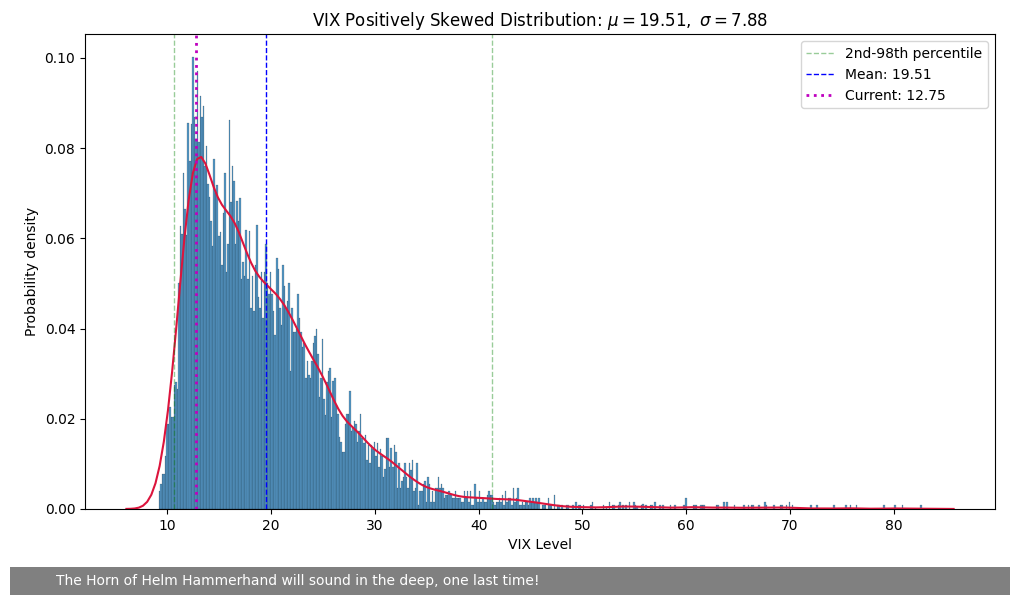

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import datetime
import pandas_market_calendars as mcal
from scipy import stats
import yfinance as yf
import seaborn as sns

yf.pdr_override()
import pandas_datareader.data as pdr

def fetch_vix_data():
    """
    Fetch VIX data from Yahoo Finance and save to CSV.
    """
    nyse = mcal.get_calendar('NYSE')
    today = datetime.date.today()
    vixDf = read_vix_data()
    last_saved_date = vixDf.index[-1]
    last_date_forward = (last_saved_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    last_traded =  pd.to_datetime(today) - pd.tseries.offsets.CustomBusinessDay(1, holidays = nyse.holidays().holidays)
    
    if last_saved_date != last_traded:
        with open('VIX.csv', 'a+') as file:
            file.write('\n')
        print(last_saved_date, last_traded)
        vix_import_df = yf.download('^VIX', end=today)
        vix_import_df = vix_import_df.reindex(columns=['Open', 'High', 'Low', 'Close'])
        vix_import_df = vix_import_df.round(2)
        vix_import_df.to_csv('VIX.csv', mode='a', header=False, encoding=None)
    else:
        print('Data is up to date.')

    print(type(vixDf))
    return vixDf

def read_vix_data():
    """
    Read VIX data from CSV file.
    """
    vixDf = pd.read_csv('VIX.csv')
    vixDf.index = pd.to_datetime(vixDf['DATE'], format='mixed')
    vixDf.drop(columns=['DATE','OPEN','HIGH','LOW'], inplace=True)
    return vixDf

def add_signature_bar(fig, text, fontsize=10, pad=5, xpos=20, ypos=7.5,
                      rect_kw={"facecolor": "grey", "edgecolor": None},
                      text_kw={"color": "w"}):
    """
    Add signature bar to the plot.
    """
    w, h = fig.get_size_inches()
    height = ((fontsize + 2 * pad) / 72.) / h
    rect = plt.Rectangle((0, 0), 1, height, transform=fig.transFigure, clip_on=False, **rect_kw)
    fig.axes[0].add_patch(rect)
    fig.text(xpos / 72. / h, ypos / 72. / h, text, fontsize=fontsize, **text_kw)
    fig.subplots_adjust(bottom=fig.subplotpars.bottom + height)

def plot_vix_distribution(vixDf):
    """
    Plot VIX distribution and statistics.
    """
    mu = np.average(vixDf['CLOSE'])  # mean of distribution
    print(stats.mode(vixDf['CLOSE']))
    num_bins = 500
    
    _, sigma = stats.norm.fit(vixDf['CLOSE'])
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjusting the figure size
    
    sns.histplot(vixDf['CLOSE'], bins=500, line_kws={'ls': ':', 'lw':2}, stat='density')
    sns.kdeplot(vixDf['CLOSE'], color='crimson')

    ax.set_xlabel('VIX Level')
    ax.set_ylabel('Probability density')
    ax.set_title(r'VIX Positively Skewed Distribution: $\mu={:.2f},\ \sigma={:.2f}$'.format(mu, sigma))
    
    fig.tight_layout() # Tweak spacing to prevent clipping of ylabel
    #1 std percentiles: 16 -> 84 
    #2 std percentiles: 2 --> 98
    ax.axvline(np.percentile(vixDf['CLOSE'], 2), color='g', alpha=0.4, linestyle='dashed', linewidth=1, label='2nd-98th percentile')
    ax.axvline(np.percentile(vixDf['CLOSE'], 98), color='g', alpha=0.4, linestyle='dashed', linewidth=1)
    ax.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Mean: {round(mu, 2)}')
    ax.axvline(vixDf['CLOSE'].iloc[-1], color='m', linestyle=':', linewidth=2, label=f'Current: {vixDf["CLOSE"].iloc[-1]}')
    # ax.axvspan(date, date + pd.DateOffset(months=1), color='grey', alpha=0.3, linewidth=0, label='Recession Period')
    plt.legend(loc="upper right")
    add_signature_bar(fig, "The Horn of Helm Hammerhand will sound in the deep, one last time!")

    plt.show()


if __name__ == "__main__":
    vixDf = fetch_vix_data()
    # print(vixDf.tail(5))
    plot_vix_distribution(vixDf)


<bound method NDFrame.tail of 1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
              ...  
2024-07-29    16.60
2024-07-30    17.69
2024-07-31    16.36
2024-08-01    18.59
2024-08-02    23.39
Length: 8728, dtype: float64>
2024-08-02


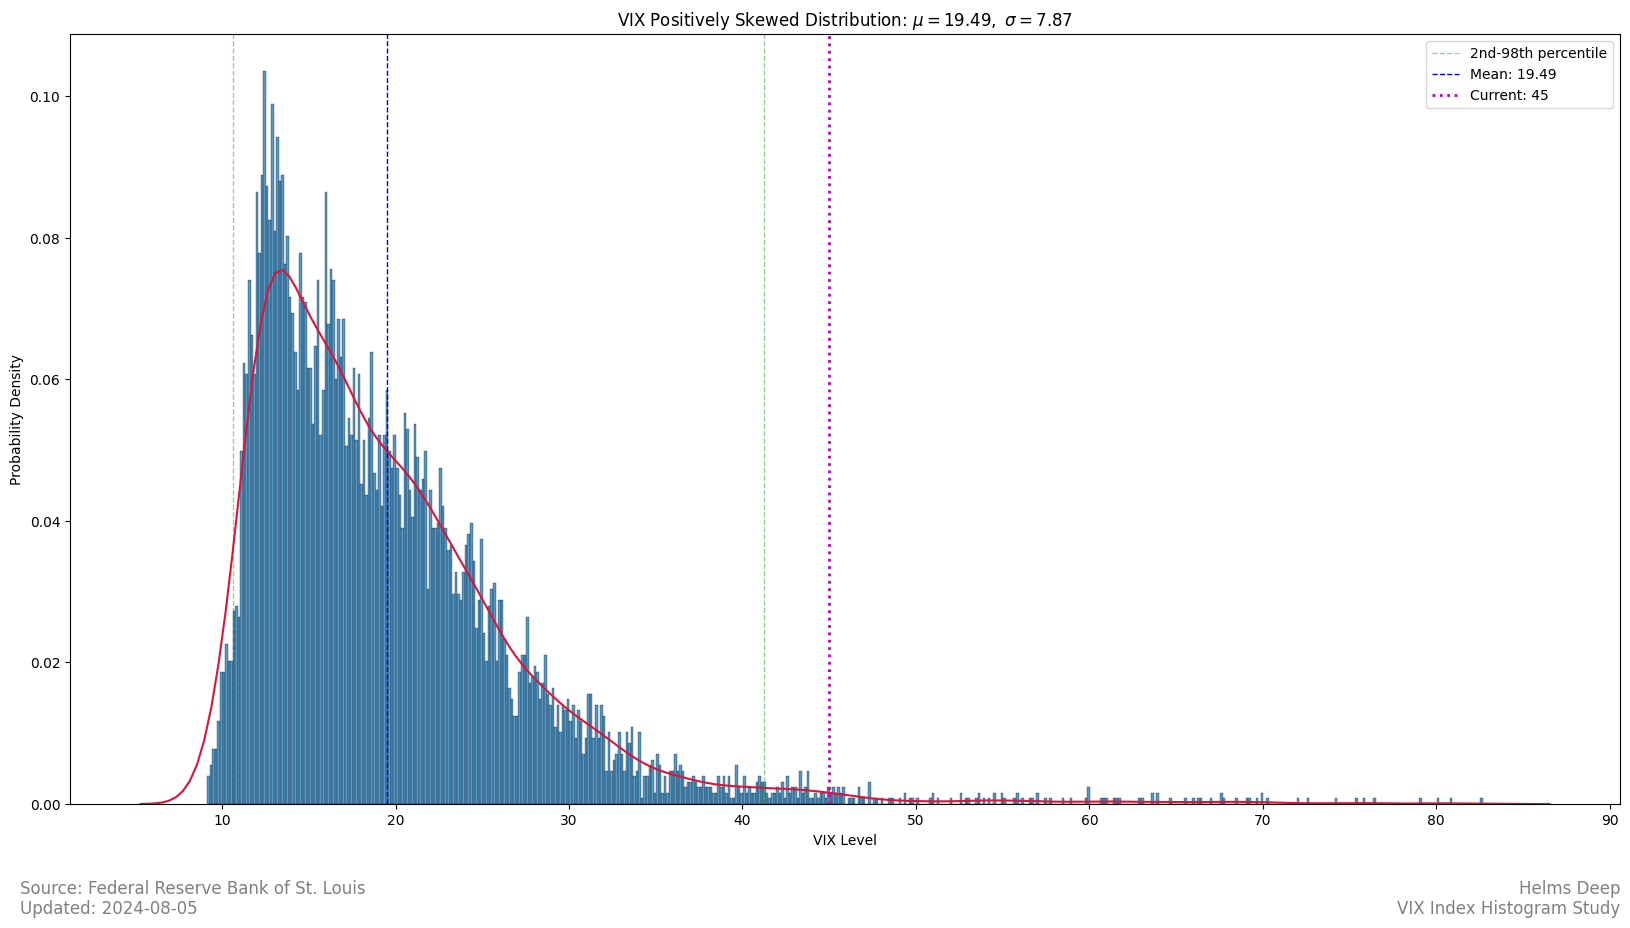

In [7]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from fredapi import Fred
import yfinance as yf
import pandas_market_calendars as mcal

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def fetch_vix_data():
    """
    Fetch VIX data from the FRED API using SeriesFetcher.
    
    Returns:
        pd.Series: A series containing VIX data.
    """
    VIXCLS = SeriesFetcher('VIXCLS')
    vix_df = VIXCLS.get_series_data()
    return vix_df

def plot_vix_distribution(vix_df):
    """
    Plot the distribution and statistics of VIX data.

    Parameters:
        vix_df (pd.Series): A series containing VIX data.
    """
    today = pd.Timestamp.now().date()
    mu = np.mean(vix_df)
    sigma = np.std(vix_df)

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.histplot(vix_df, bins=500, stat='density', kde=False)
    sns.kdeplot(vix_df, color='crimson')

    ax.set_xlabel('VIX Level')
    ax.set_ylabel('Probability Density')
    ax.set_title(r'VIX Positively Skewed Distribution: $\mu={:.2f},\ \sigma={:.2f}$'.format(mu, sigma))
    
    ax.axvline(np.percentile(vix_df, 2), color='g', alpha=0.4, linestyle='dashed', linewidth=1, label='2nd-98th percentile')
    ax.axvline(np.percentile(vix_df, 98), color='g', alpha=0.4, linestyle='dashed', linewidth=1)
    ax.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Mean: {round(mu, 2)}')
    ax.axvline(45, color='m', linestyle=':', linewidth=2, label=f'Current: {45}')

    most_recent_date = vix_df.index.max()
    print(most_recent_date)
    # plt.text(0.98, 0.98, f'Most Recent Data: {most_recent_date.date()}', 
    #          transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')

    # Add signature text to the plot
    signature_text = 'Helms Deep\nVIX Index Histogram Study'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    plt.legend(loc="upper right")
    # add_signature_bar(fig, "The Horn of Helm Hammerhand will sound in the deep, one last time!")

    plt.show()
    fig.savefig('VIX Histogram.png', bbox_inches='tight')

if __name__ == "__main__":
    vix_df = fetch_vix_data()
    print(vix_df.tail)
    plot_vix_distribution(vix_df)


1990-01-03 00:00:00


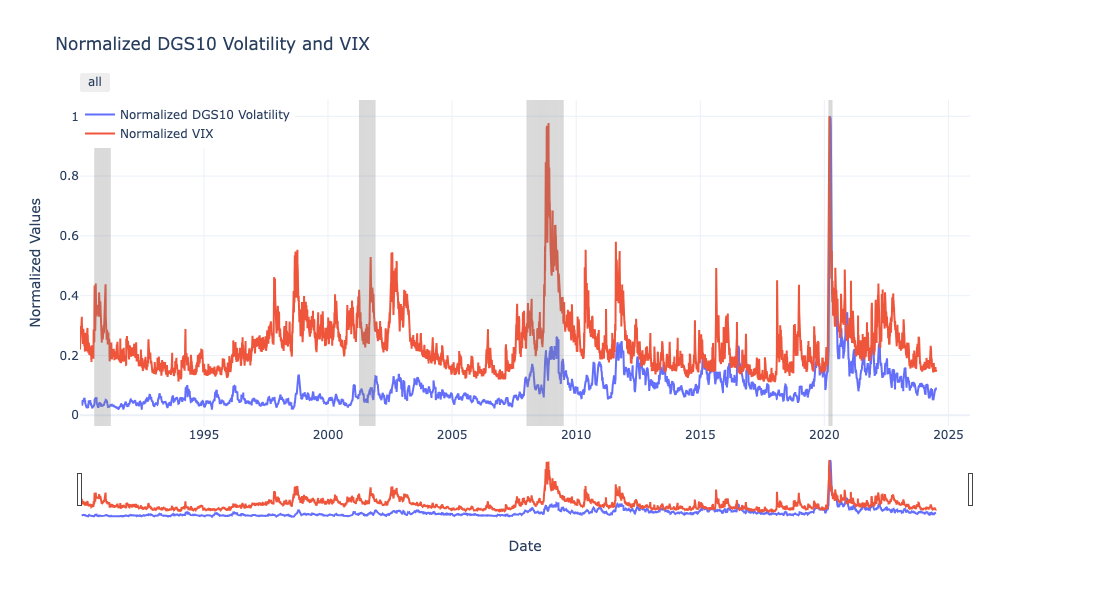

In [6]:
import os
import sys
import pandas as pd
import plotly.graph_objs as go
from datetime import datetime as dt
from plotly.subplots import make_subplots

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher


def shade_recession_months(fig, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )


# Fetch DGS10 data (Yield on U.S. Treasury Securities at 10-Year)
dgs10_fetcher = SeriesFetcher('DGS10')
dgs10_data = dgs10_fetcher.get_series_data()

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Convert index to datetime
dgs10_data.index = pd.to_datetime(dgs10_data.index)
vix_data.index = pd.to_datetime(vix_data.index)

# Align both datasets on the same date index
combined_data = pd.DataFrame({'DGS10': dgs10_data, 'VIX': vix_data}).dropna()

# Specify arbitrary start date
# start_date = dt.strptime('01-01-2020', "%m-%d-%Y")

# Filter data based on start date

start_date = combined_data.index[1] 

print(start_date)
combined_data = combined_data.loc[start_date:]

# Calculate Historical (Realized) Volatility for DGS10
combined_data['DGS10_Returns'] = combined_data['DGS10'].pct_change()
combined_data['DGS10_Volatility'] = combined_data['DGS10_Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
combined_data['Normalized_DGS10_Volatility'] = combined_data['DGS10_Volatility'] / combined_data['DGS10_Volatility'].max()
combined_data['Normalized_VIX'] = combined_data['VIX'] / combined_data['VIX'].max()

# Create the plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Normalized DGS10 Volatility trace
fig.add_trace(
    go.Scatter(x=combined_data.index, y=combined_data['Normalized_DGS10_Volatility'],
               mode='lines', name='Normalized DGS10 Volatility', line=dict(dash='solid')),
    secondary_y=False,
)

# Add Normalized VIX trace
fig.add_trace(
    go.Scatter(x=combined_data.index, y=combined_data['Normalized_VIX'],
               mode='lines', name='Normalized VIX', line=dict(dash='solid')),
    secondary_y=False,
)

# Set x-axis limits to include additional offset days
offset_days = 500
x_min = combined_data.index.min()
x_max = combined_data.index.max() + pd.DateOffset(days=offset_days)
fig.update_xaxes(range=[x_min, x_max])

# Shade the recession periods based on the "USREC" series
USREC = SeriesFetcher('USREC')
usrec_series = USREC.get_series_data(x_min)
shade_recession_months(fig, usrec_series)

# Update layout with custom size and legend position
fig.update_layout(
    title='Normalized DGS10 Volatility and VIX',
    xaxis_title='Date',
    yaxis_title='Normalized Values',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    template='plotly_white',
    width=1200,  # Set the width of the plot
    height=600,   # Set the height of the plot
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
    )
)

# Show the plot
fig.show()


2024-07-29    16.60
2024-07-30    17.69
2024-07-31    16.36
2024-08-01    18.59
2024-08-02    23.39
dtype: float64


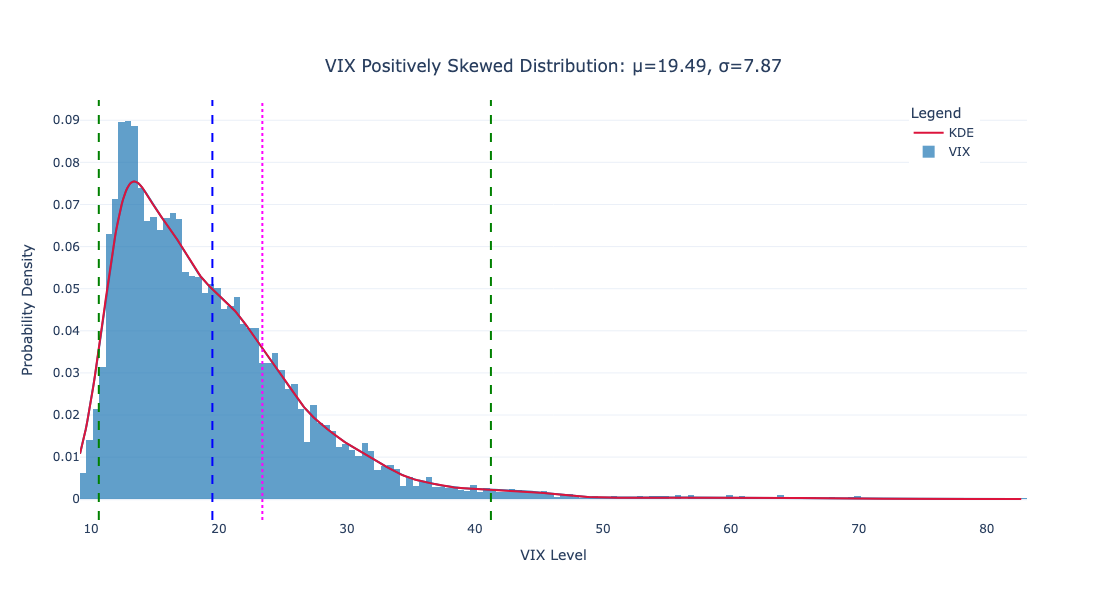

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.figure_factory as ff
from datetime import datetime
from fredapi import Fred
from scipy.stats import gaussian_kde
import importlib

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def fetch_vix_data():
    """
    Fetch VIX data from the FRED API using SeriesFetcher.
    
    Returns:
        pd.Series: A series containing VIX data.
    """
    VIXCLS = SeriesFetcher('VIXCLS')
    vix_df = VIXCLS.get_series_data()
    return vix_df

def plot_vix_distribution(vix_df):
    """
    Plot the distribution and statistics of VIX data using Plotly.

    Parameters:
        vix_df (pd.Series): A series containing VIX data.
    """
    today = pd.Timestamp.now().date()
    mu = np.mean(vix_df)
    sigma = np.std(vix_df)

    hist_data = [vix_df]
    group_labels = ['VIX']

    # Create distplot with custom bin_size
    fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5, show_rug=False)

    # Compute KDE using gaussian_kde
    kde = gaussian_kde(vix_df)
    x_vals = np.linspace(min(vix_df), max(vix_df), 1000)
    kde_vals = kde(x_vals)

    # Add KDE plot
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=kde_vals,
            mode='lines',
            name='KDE',
            line=dict(color='crimson')
        )
    )

    # Add vertical lines for mean and percentiles
    fig.add_vline(x=np.percentile(vix_df, 2), line=dict(color='green', dash='dash'), annotation_text='2nd percentile', annotation_position='top left')
    fig.add_vline(x=np.percentile(vix_df, 98), line=dict(color='green', dash='dash'), annotation_text='98th percentile', annotation_position='top right')
    fig.add_vline(x=mu, line=dict(color='blue', dash='dash'), annotation_text=f'Mean: {mu:.2f}', annotation_position='top left')
    fig.add_vline(x=vix_df.iloc[-1], line=dict(color='magenta', dash='dot'), annotation_text=f'Current: {vix_df.iloc[-1]:.2f}', annotation_position='top right')

    # Update layout
    fig.update_layout(
        title={
            'text': f'VIX Positively Skewed Distribution: μ={mu:.2f}, σ={sigma:.2f}',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='VIX Level',
        yaxis_title='Probability Density',
        legend_title='Legend',
        legend=dict(
            x=.95,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the plot
        height=600,   # Set the height of the plot
        annotations=[
            dict(
                text=f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}',
                xref='paper', yref='paper',
                x=0, y=-0.2,
                showarrow=False,
                font=dict(size=12, color='grey'),
                xanchor='left', yanchor='top'
            ),
            dict(
                text='Helms Deep\nVIX Index Histogram Study',
                xref='paper', yref='paper',
                x=1, y=-0.2,
                showarrow=False,
                font=dict(size=12, color='grey'),
                xanchor='right', yanchor='top'
            )
        ]
    )

    # Show the plot
    fig.show()

if __name__ == "__main__":
    vix_df = fetch_vix_data()
    print(vix_df.tail())
    plot_vix_distribution(vix_df)
